In [4]:
import pandas as pd
import numpy as np
from scipy import sparse
import time
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [5]:
dfr = pd.read_pickle('data/YelpReviewStemmed.pkl.gz')

In [6]:
print(len(dfr))
dfr = dfr.dropna(subset=['business_id', 'stars','stemmed_text'])
print(len(dfr))

4747892
4747852


In [7]:
corpus = list(dfr.stemmed_text)
y      = list(dfr.sentiment)
del dfr

# TF-IDF Vectorization

In [8]:
tfidf = TfidfVectorizer(max_features=10000)

start_time = time.time()
X_raw = tfidf.fit_transform(corpus)
y_raw = y
print('--- {0} seconds ---'.format( time.time() - start_time ))

joblib.dump(tfidf, 'models/TFIDF_model.joblib')
del corpus

--- 203.7308909893036 seconds ---


In [9]:
print(X_raw.shape)
# print(tfidf.get_feature_names())

(4747852, 10000)


# Split data into training and test sets

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.25, random_state=88)
del X_raw, y_raw

# Logistic Regression on full matrix

In [8]:
logreg = LogisticRegression(random_state=34, solver='lbfgs', max_iter=1000)

start_time = time.time()
logreg.fit(X_train, y_train)
print('--- {0} seconds ---'.format( time.time() - start_time ))

joblib.dump(logreg, 'models/LogReg_model_noSVD.joblib')

--- 187.95039105415344 seconds ---


['models/LogReg_model_noSVD.joblib']

In [ ]:
start_time = time.time()
y_pred = logreg.predict(X_test)
print('--- {0} seconds ---'.format( time.time() - start_time ))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

--- 0.1628117561340332 seconds ---
Accuracy of logistic regression classifier on test set: 0.90


In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[334404  73696]
 [ 49431 729432]]


# Dimension reduction via Truncated SVD

In [ ]:
svd = TruncatedSVD(n_components=300)

start_time = time.time()
X_train_svd = svd.fit_transform(X_train)
print('--- {0} seconds ---'.format( time.time() - start_time ))

joblib.dump(svd, 'models/SVD_model.joblib')

start_time = time.time()
X_test_svd = svd.transform(X_test)
print('--- {0} seconds ---'.format( time.time() - start_time ))

# print(svd.explained_variance_ratio_)  
# print(svd.explained_variance_ratio_.sum())  
# print(svd.singular_values_)

del X_train

--- 2725.411073207855 seconds ---
--- 11.517033100128174 seconds ---


Total explained variance ratio: 0.36106978450666705


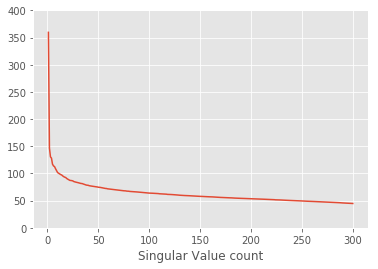

In [ ]:
fig, ax = plt.subplots()
svs_ = svd.singular_values_
ax.plot(range(1,len(svs_)+1), svs_, '-')
plt.ylim([0,400])
plt.xlabel('Singular Value count')
print('Total explained variance ratio: {0}'.format( svd.explained_variance_ratio_.sum())) 

# Logistic Regression classifier

In [ ]:
logreg = LogisticRegression(random_state=34, solver='lbfgs')

start_time = time.time()
logreg.fit(X_train_svd, y_train)
print('--- {0} seconds ---'.format( time.time() - start_time ))

joblib.dump(logreg, 'models/LogReg_model.joblib')

--- 98.60977101325989 seconds ---


['models/LogReg_model.joblib']

In [ ]:
start_time = time.time()
y_pred = logreg.predict(X_test_svd)
print('--- {0} seconds ---'.format( time.time() - start_time ))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_svd, y_test)))

--- 2.218111991882324 seconds ---
Accuracy of logistic regression classifier on test set: 0.87


In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[318948  89152]
 [ 62315 716548]]


# Gaussian Naive Bayes classifier

In [ ]:
gnb = GaussianNB()

start_time = time.time()
gnb.fit(X_train_svd, y_train)
print('--- {0} seconds ---'.format( time.time() - start_time ))

joblib.dump(gnb, 'models/GNB_model.joblib')

--- 155.595388174057 seconds ---


['models/GNB_model.joblib']

In [ ]:
start_time = time.time()
y_pred = gnb.predict(X_test_svd)
print('--- {0} seconds ---'.format( time.time() - start_time ))
print('Accuracy of Gaussian Naive Bayes classifier on test set: {:.2f}'.format(gnb.score(X_test_svd, y_test)))

--- 19.64249014854431 seconds ---
Accuracy of Gaussian Naive Bayes classifier on test set: 0.69


In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[299328 108772]
 [254737 524126]]


# Undersampling 100000 training and 20000 test

In [29]:
us = np.random.permutation(range(X_train.shape[0]))[:100000]
X_train_svd_us = X_train_svd[us,:]
y_train_us = np.array(y_train)[us]

In [30]:
us = np.random.permutation(range(X_test.shape[0]))[:20000]
X_test_svd_us = X_test_svd[us,:]
y_test_us = np.array(y_test)[us]

# Logistic Regression on undersampled data

In [31]:
logreg = LogisticRegression(random_state=34, solver='lbfgs')

start_time = time.time()
logreg.fit(X_train_svd_us, y_train_us)
print('--- {0} seconds ---'.format( time.time() - start_time ))

--- 1.573659896850586 seconds ---


['models/LogReg_model.joblib']

In [32]:
start_time = time.time()
y_pred = logreg.predict(X_test_svd_us)
print('--- {0} seconds ---'.format( time.time() - start_time ))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_svd_us, y_test_us)))

--- 0.012654781341552734 seconds ---
Accuracy of logistic regression classifier on test set: 0.87


# Linear Support Vector Machine on undersampled data

In [33]:
lsvm = LinearSVC(random_state=845, tol=1e-5)

start_time = time.time()
lsvm.fit(X_train_svd_us, y_train_us)
print('--- {0} seconds ---'.format( time.time() - start_time ))

joblib.dump(lsvm, 'models/LSVM_model.joblib')

--- 4.63019585609436 seconds ---


['models/LSVM_model.joblib']

In [34]:
start_time = time.time()
y_pred = lsvm.predict(X_test_svd_us)
print('--- {0} seconds ---'.format( time.time() - start_time ))
print('Accuracy of Linear SVM classifier on test set: {:.2f}'.format(lsvm.score(X_test_svd_us, y_test_us)))

--- 0.014034032821655273 seconds ---
Accuracy of Linear SVM classifier on test set: 0.87


In [35]:
conf_mat = confusion_matrix(y_test_us, y_pred)
print(conf_mat)

[[ 5425  1470]
 [ 1046 12059]]


# Random Forest classifier on undersampled data

In [39]:
rfc = RandomForestClassifier(n_estimators=30, max_depth=30, random_state=214)
# rfc = RandomForestClassifier(n_estimators=10)

start_time = time.time()
rfc.fit(X_train_svd_us, y_train_us)
print('--- {0} seconds ---'.format( time.time() - start_time ))

joblib.dump(rfc, 'models/RFC_model.joblib')

--- 62.81726384162903 seconds ---


['models/RFC_model.joblib']

In [40]:
start_time = time.time()
y_pred = rfc.predict(X_test_svd)
print('--- {0} seconds ---'.format( time.time() - start_time ))
print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(rfc.score(X_test_svd_us, y_test_us)))

--- 11.814661264419556 seconds ---
Accuracy of Random Forest classifier on test set: 0.80


In [41]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[234545 173555]
 [ 59524 719339]]
